# SEIAQRDV

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import deepxde as dde
import seaborn as sns

from deepxde.backend import tf
from scipy.integrate import odeint

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.facecolor":"white"})

# dde.config.real.set_float64()
%matplotlib inline

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


2022-07-11 23:06:39.722313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-11 23:06:39.786672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-11 23:06:39.787071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Enable just-in-time compilation with XLA.




## Model

$$
\begin{aligned}
\dot{S} &= - \frac{\beta}{N} S (I^A + I^S) - \alpha S \\
\dot{E} &= \frac{\beta}{N} S (I^A + I^S) - \sigma E \\
\dot{I^S} &= p \sigma E + (1 - \nu ) \omega I^A - \xi I^S \\
\dot{I^A} &= (1 - p) \sigma E - \omega I^A \\
\dot{Q} &= \xi I^S - \gamma Q \\
\dot{R} &= \nu \omega I^A + (1 - q) \gamma Q \\
\dot{D} &= q \gamma Q \\
\dot{V} &= \alpha S 
\end{aligned}
$$

- Susceptible (S): Individuals who have not been infected with COVID-19 and have not isolated themselves
from the population
- Exposed (E): Individuals in the incubation period of disease progression
- Asymptomatic (IA): Infectious individuals who do not show symptoms of COVID-19
- Symptomatic (IS): Infectious individuals who show symptoms of COVID-19
- Hospitalized (H): Infectious individuals, hospitalized with symptoms of COVID-19
- Quarantine (Q): Symptomatic infectious individuals who are isolated
- Recovered (R): Individuals who survived COVID-19
- Dead (D): Individuals who did not survive COVID-19

- $\beta$ Transmission Rate
- $\sigma$ Rate at which Exposed individuals become Infected
- $\omega$: Rate at which Asymptomatic individuals become Symptomatic or Recovered
- $\xi$: Rate at which Symptomatic individuals become Quarantined
- $\gamma$: Rate at which Quarantined individuals become Hospitalized or Recovered
- $p$: Fraction of Symptomatic individuals out of Exposed individuals
- $q$: Fraction of Hospitalized individuals out of Quarantined individuals
- $\nu$: Fraction of Recovered individuals out of Asymptomatic individuals
- $\alpha$: Vaccination Rate

## Initial Conditions

In [2]:
N = 1e7
beta = 0.5
sigma = 1 / 6
omega = 1 / 14
xi = 0.5
gamma = 1 / 5
p = 0.6
q = 0.19
nu = 0.5
alpha = 0.01
parameters_real = [beta, sigma, omega, xi, gamma, p, q, nu, alpha]

t = np.arange(0, 300, 10)[:, np.newaxis]

## Generate Data

In [3]:
def seiaqrdv_model(
    t,
    N,
    beta,
    sigma,
    omega,
    xi,
    gamma,
    p,
    q,
    nu,
    alpha
):
    def func(y, t):
        S, E, I, A, Q, R, D, V = y
        dS = - beta / N * S * (I + A) - alpha * S
        dE = beta / N * S * (I + A) - sigma * E
        dI = p * sigma * E + (1 - nu) * omega * A - xi * I
        dA =  (1 - p) * sigma * E - omega * A
        dQ = xi * I - gamma * Q
        dR = nu * omega * A + (1 - q) * gamma * Q
        dD = q * gamma * Q
        dV = alpha * S
        return [dS, dE, dI, dA, dQ, dR, dD, dV]
    
    S_0 = N - 1000
    E_0 = 1000
    I_0 = 0
    A_0 = 0
    Q_0 = 0
    R_0 = 0
    D_0 = 0
    V_0 = 0
    y0 = [S_0, E_0, I_0, A_0, Q_0, R_0, D_0, V_0]
    return odeint(func, y0, t)

In [4]:
y = seiaqrdv_model(np.ravel(t), N, beta, sigma, omega, xi, gamma, p, q, nu, alpha)
y_noise1 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.01
y_noise5 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.05
y_noise10 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.1

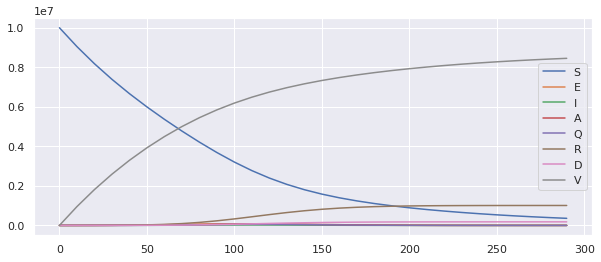

In [5]:
names = list("SEIAQRDV")
fig, ax = plt.subplots(figsize=(10, 4))
for v, name in zip(y.T, names):
    ax.plot(np.ravel(t), v, label=name)
plt.legend()
plt.show()

## DINN

In [6]:
def dinn(data_t, data_y, N):    
    
    # Variables
    beta = tf.math.sigmoid(dde.Variable(0.1))
    sigma = tf.math.sigmoid(dde.Variable(0.1))
    omega = tf.math.sigmoid(dde.Variable(0.1))
    xi = tf.math.sigmoid(dde.Variable(0.1))
    gamma = tf.math.sigmoid(dde.Variable(0.1))
    p = tf.math.sigmoid(dde.Variable(0.1))
    q = tf.math.sigmoid(dde.Variable(0.1))
    nu = tf.math.sigmoid(dde.Variable(0.1))
    alpha = tf.math.sigmoid(dde.Variable(0.1))
    variable_list = [beta, sigma, omega, xi, gamma, p, q, nu, alpha]
    
    # ODE model
    def ODE(t, y):
        S = y[:, 0:1]
        E = y[:, 1:2]
        I = y[:, 2:3]
        A = y[:, 3:4]
        Q = y[:, 4:5]
        R = y[:, 5:6]
        D = y[:, 6:7]
        V = y[:, 7:8]
        
        dS_t = dde.grad.jacobian(y, t, i=0)
        dE_t = dde.grad.jacobian(y, t, i=1)
        dI_t = dde.grad.jacobian(y, t, i=2)
        dA_t = dde.grad.jacobian(y, t, i=3)
        dQ_t = dde.grad.jacobian(y, t, i=4)
        dR_t = dde.grad.jacobian(y, t, i=5)
        dD_t = dde.grad.jacobian(y, t, i=6)
        dV_t = dde.grad.jacobian(y, t, i=7)
        
        return [
            dS_t - (- beta / N * S * (I + A) - alpha * S),
            dE_t - (beta / N * S * (I + A) - sigma * E),
            dI_t - (p * sigma * E + (1 - nu) * omega * A - xi * I),
            dA_t - ( (1 - p) * sigma * E - omega * A),
            dQ_t - (xi * I - gamma * Q),
            dR_t - (nu * omega * A + (1 - q) * gamma * Q),
            dD_t - (q * gamma * Q),
            dV_t - (alpha * S),
        ]
    
    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    ic_S = dde.icbc.IC(geom, lambda x: N- 1000, boundary, component=0)
    ic_E = dde.icbc.IC(geom, lambda x: 1000, boundary, component=1)
    ic_I = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)
    ic_A = dde.icbc.IC(geom, lambda x: 0, boundary, component=3)
    ic_Q = dde.icbc.IC(geom, lambda x: 0, boundary, component=4)
    ic_R = dde.icbc.IC(geom, lambda x: 0, boundary, component=5)
    ic_D = dde.icbc.IC(geom, lambda x: 0, boundary, component=6)
    ic_V = dde.icbc.IC(geom, lambda x: 0, boundary, component=7)

    # Train data
    observe_S = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_E = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_I = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_A = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    observe_Q = dde.icbc.PointSetBC(data_t, data_y[:, 4:5], component=4)
    observe_R = dde.icbc.PointSetBC(data_t, data_y[:, 5:6], component=5)
    observe_D = dde.icbc.PointSetBC(data_t, data_y[:, 6:7], component=6)
    observe_V = dde.icbc.PointSetBC(data_t, data_y[:, 7:8], component=7)
    
    # Model
    data = dde.data.PDE(
        geom,
        ODE,
        [
            ic_S,
            ic_E,
            ic_I,
            ic_A,
            ic_Q,
            ic_R,
            ic_D,
            ic_V,
            observe_S,
            observe_E,
            observe_I,
            observe_A,
            observe_Q,
            observe_R,
            observe_D,
            observe_V
        ],
        num_domain=200,
        num_boundary=2,
        anchors=data_t,
    )
    
    net = dde.nn.FNN([1] + [128] * 3 + [8], "relu", "Glorot uniform")
    
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    # def output_transform(t, y):
    #     # return tf.constant([1, 1, 1e2, 1, 1, 1]) * y
    #     return tf.abs(y)

    net.apply_feature_transform(feature_transform)
    # net.apply_output_transform(output_transform)

    iterations = 100000
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=8 * [1] + 8 * [1] + 8 * [5],
        external_trainable_variables=variable_list
    )
    variable = dde.callbacks.VariableValue(
        variable_list,
        period=5000,
        filename="variables_seiaqrdv.dat"
    )
    losshistory, train_state = model.train(
        iterations=iterations,
        display_every=10000,
        callbacks=[variable]
      )
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    return model, variable, losshistory, train_state

Compiling model...
Building feed-forward neural network...
'build' took 0.042884 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-07-11 23:06:40.996447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 23:06:41.000100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] cou

'compile' took 2.003242 s

Initializing variables...


2022-07-11 23:06:42.976914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-07-11 23:06:43.070267: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7fa45c0182f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-11 23:06:43.070303: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2022-07-11 23:06:43.188611: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-11 23:06:43.239725: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-07-11 23:06:43.324697: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Training model...

Step      Train loss                                                                                                                                                                                                                                          Test loss                                                                                                                                                                                                                                           Test metric
0         [5.82e-04, 2.14e-04, 2.42e-03, 1.86e-04, 3.21e-04, 1.78e-05, 5.07e-05, 5.74e-04, 1.00e+14, 1.00e+06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 8.50e+13, 6.79e+09, 4.68e+08, 5.52e+09, 2.90e+09, 2.64e+12, 8.53e+10, 2.23e+14]    [5.82e-04, 2.14e-04, 2.42e-03, 1.86e-04, 3.21e-04, 1.78e-05, 5.07e-05, 5.74e-04, 1.00e+14, 1.00e+06, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 8.50e+13, 6.79e+09, 4.68e+08, 5.52e+09, 2.90e+09, 2.64e+

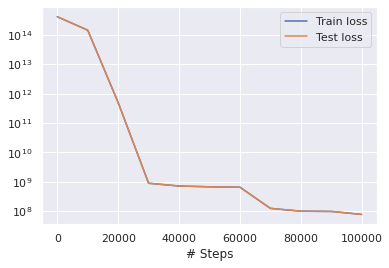

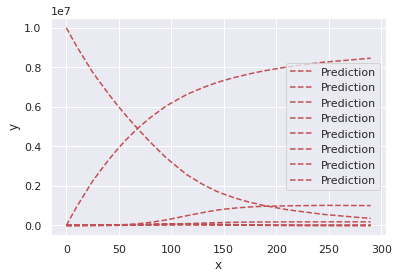

In [7]:
model, variable, losshistory, train_state = dinn(t, y, N)

## Postprocessing

In [8]:
parameter_names = [
  "beta",
  "sigma",
  "omega",
  "xi",
  "gamma",
  "p",
  "q",
  "nu",
  "alpha",
]
errors = (
    pd.DataFrame(
        {
            "real": parameters_real,
            "predicted": variable.value
        },
        index=parameter_names
    )
    .assign(
        relative_error=lambda x: (x["real"] - x["predicted"]).abs() / x["real"] * 100
    )
)
errors.to_excel("SEIAQRDV_errors.xlsx")
errors

,real,predicted,relative_error
beta,0.500000,0.506925,1.385021
sigma,0.166667,0.168079,0.847456
omega,0.071429,0.071304,0.174399
xi,0.500000,0.506964,1.392746
gamma,0.200000,0.201859,0.929692
p,0.600000,0.599829,0.028567
q,0.190000,0.189889,0.058390
nu,0.500000,0.475773,4.845321
alpha,0.010000,0.009960,0.395824


In [9]:
print(
    errors.style
    .format(
        {
            "real": "{:.4f}",
            "predicted": "{:.4f}",
            "relative_error": "{:.2f}",
        }
    ).to_latex(
        label="tab:sirdt_errors",
        caption="Parameter predictions and relative errors.",   
    )
)

\begin{table}
\caption{Parameter predictions and relative errors.}
\label{tab:sirdt_errors}
\begin{tabular}{lrrr}
 & real & predicted & relative_error \\
beta & 0.5000 & 0.5069 & 1.39 \\
sigma & 0.1667 & 0.1681 & 0.85 \\
omega & 0.0714 & 0.0713 & 0.17 \\
xi & 0.5000 & 0.5070 & 1.39 \\
gamma & 0.2000 & 0.2019 & 0.93 \\
p & 0.6000 & 0.5998 & 0.03 \\
q & 0.1900 & 0.1899 & 0.06 \\
nu & 0.5000 & 0.4758 & 4.85 \\
alpha & 0.0100 & 0.0100 & 0.40 \\
\end{tabular}
\end{table}



In [10]:
df_real = (
    pd.DataFrame(y, columns=names, index=t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

full_t = np.arange(0, 300)[:, np.newaxis]
y_pred = model.predict(full_t)
df_pred = (
    pd.DataFrame(y_pred, columns=names, index=full_t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)
df_pred.head()

,time,status,population
0,0,S,9999453.0
1,1,S,9903239.0
2,2,S,9806769.0
3,3,S,9711331.0
4,4,S,9616471.0


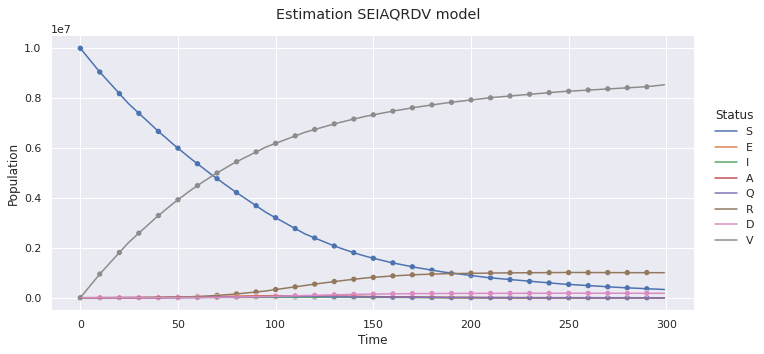

In [11]:
sns.set(rc={"figure.facecolor":"white"})

g = sns.relplot(
    data=df_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    # height=8,
    aspect=2,
)

sns.scatterplot(
    data=df_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)


(
    g.set_axis_labels("Time", "Population")
      .set_titles("Zone {row_name}")
      .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Estimation SEIAQRDV model")
plt.savefig("SEIAQRDV_estimation.png", dpi=300)
plt.show()